# Coffee Roast Curve Analysis - Modular Version

This notebook demonstrates the same analytical capabilities as the original Evaluating_ROR.ipynb but imports all functions from the consolidated main.py module for better code organization and reusability.

## Setup and Imports

Import all the necessary functions from our main.py module.

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import all functions from our consolidated main.py module
from main import (
    # ALOG Parser functions
    extract_roast_data,
    load_roast_data_as_dataframe,
    get_roast_summary,
    
    # Data Processing functions
    annotate_roast_events,
    add_charge_drop_segments,
    hampel_filter,
    clean_segments_and_recalc_ror,
    regularize_segments,
    calculate_development_ratio,
    get_roast_phases,
    filter_valid_roasts,
    process_roast_data,
    
    # Scoring Engine functions
    score_ror_curve,
    score_roast_timing,
    score_temperature_profile,
    score_development_ratio,
    calculate_composite_score,
    score_roast_dataframe,
    get_scoring_summary,
    
    # Plotting functions
    plot_roast,
    plot_all_curves,
    plot_score_analysis,
    
    # Main pipeline
    analyze_roasts
)

print("✓ All modules imported successfully from main.py")

✓ All modules imported successfully from main.py


## 1. Single Roast Analysis

Let's start by analyzing a single roast file to understand the data structure and visualization capabilities.

Analyzing sample roast: 24-11-16_1129.alog
Roast duration: 10.1 minutes
Charge temperature: 393.8°F
Peak RoR: 46.1°F/min


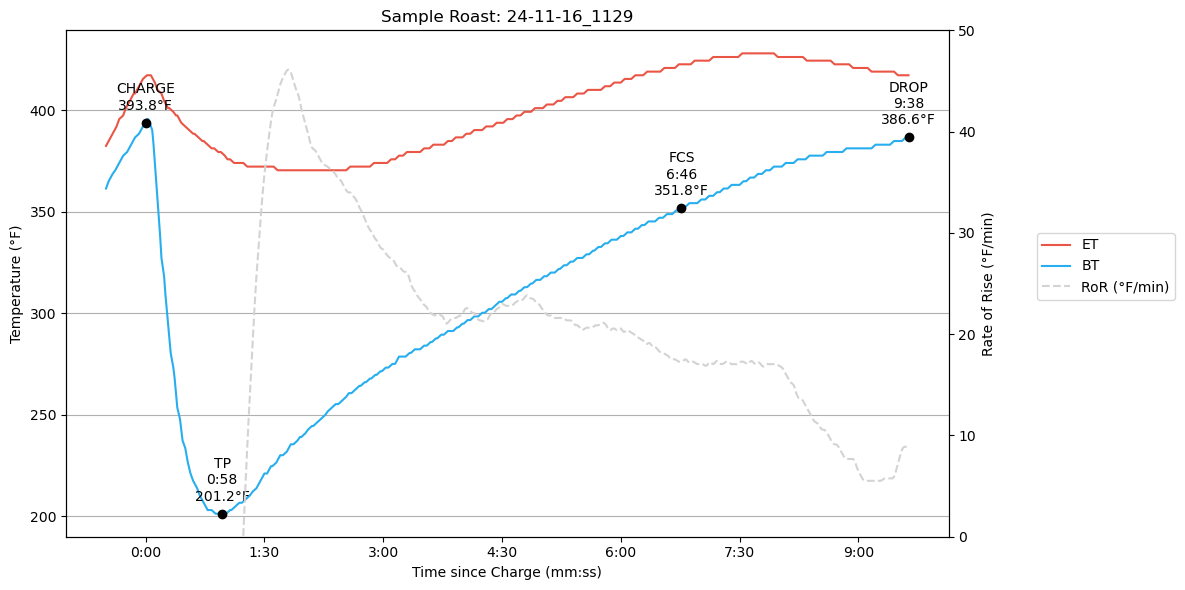

In [3]:
# Select a sample roast file
data_folder = Path("data")
sample_file = next(data_folder.glob("*.alog"), None)

if sample_file:
    print(f"Analyzing sample roast: {sample_file.name}")
    
    # Extract roast data
    roast_data = extract_roast_data(sample_file)
    
    # Display basic information
    print(f"Roast duration: {roast_data['indices']['drop'] / 60:.1f} minutes")
    print(f"Charge temperature: {roast_data['charge_bt']:.1f}°F")
    print(f"Peak RoR: {np.max(roast_data['ror']):.1f}°F/min")
    
    # Plot the roast curve
    plot_roast(roast_data, title=f"Sample Roast: {sample_file.stem}")
    
else:
    print("No .alog files found in data folder")

## 2. Load and Explore All Roast Data

Now let's load all the roast data and get an overview of our dataset.

In [4]:
# Load all roast data
print("Loading all roast data...")
df = load_roast_data_as_dataframe("data")

print(f"\nLoaded {len(df)} roasts")

# Get summary statistics
summary = get_roast_summary(df)
print("\nDataset Summary:")
print(f"  Total roasts: {summary['total_roasts']}")
print(f"  Average duration: {summary['avg_duration']:.1f} seconds ({summary['avg_duration']/60:.1f} minutes)")
print(f"  Average drop temp: {summary['avg_drop_temp']:.1f}°F")
print(f"  Temperature range:")
print(f"    Drop: {summary['temp_range']['min_drop']:.1f}°F - {summary['temp_range']['max_drop']:.1f}°F")
print(f"    Charge: {summary['temp_range']['min_charge']:.1f}°F - {summary['temp_range']['max_charge']:.1f}°F")

# Display first few rows
print("\nFirst 3 roasts:")
display(df[['filename', 'charge_bt', 'drop_time', 'drop_bt', 'tp_time', 'fcs_time']].head(3))

Loading all roast data...
Failed files summary:
  20-04-11_2032-4th-roast.alog: missing ['CHARGE_ET', 'CHARGE_BT', 'DROP_time', 'DROP_ET', 'DROP_BT']
  20-11-14_0933.alog: missing ['FCs_time/FCe_time', 'FCs_ET/FCe_ET', 'FCs_BT/FCe_BT']
  20-10-23_2249.alog: missing ['DROP_time', 'DROP_ET', 'DROP_BT']
  20-04-10_1821-3rd-roast.alog: missing ['CHARGE_ET', 'CHARGE_BT', 'DROP_time', 'DROP_ET', 'DROP_BT']
  20-04-12_2223-7th-manual-french.alog: missing ['DROP_time', 'DROP_ET', 'DROP_BT']
  20-07-09_2224-batch-1-220g.alog: missing ['DROP_time', 'DROP_ET', 'DROP_BT']
  20-10-08_2201.alog: missing ['FCs_time/FCe_time', 'FCs_ET/FCe_ET', 'FCs_BT/FCe_BT']
  20-06-02_1957-super-sonic-230g-mess.alog: missing ['CHARGE_ET', 'CHARGE_BT', 'DROP_time', 'DROP_ET', 'DROP_BT']
  20-10-28_2143.alog: missing ['FCs_time/FCe_time', 'FCs_ET/FCe_ET', 'FCs_BT/FCe_BT']
  20-04-25_2112-mill-city-colombia-rsc.alog: missing ['DROP_time', 'DROP_ET', 'DROP_BT']
  21-01-22_2220-nightmare.alog: missing ['FCs_time/FCe_tim

,filename,charge_bt,drop_time,drop_bt,tp_time,fcs_time
0,24-11-16_1129,393.8,578.0,386.6,58.0,406.0
1,20-08-07_2030,376.9,584.0,420.5,64.0,444.0
2,20-05-16_1121-mill-city-rsc-batch-1,353.5,672.0,417.1,62.0,458.0


## 3. Complete Data Processing Pipeline

Let's process all the roast data through our complete pipeline: annotation, segmentation, cleaning, and regularization.

In [5]:
# Run the complete processing pipeline
processed_df = process_roast_data(df, filter_data=True, n_points=200)

print(f"\nProcessing complete! Final dataset: {len(processed_df)} roasts")
print(f"Columns added: {len(processed_df.columns) - len(df.columns)} new columns")

# Show some of the new columns
new_columns = ['charge_time', 'dev_ratio', 'drying_time', 'maillard_time', 'development_time']
print("\nSample of processed data:")
display(processed_df[['filename'] + new_columns].head(3))

Starting data processing pipeline...
1. Annotating roast events...
2. Filtering valid roasts...
Filtered 165 roasts, 31 remaining
3. Adding charge-drop segments...
4. Cleaning data and recalculating RoR...


/Users/kunim2/bin/coffee_analytics/roast-curve-analysis/main.py:261: UserWarning: No charge match in 20-08-07_2030
  warnings.warn(f"No charge match in {row.get('filename', 'row')}")
/Users/kunim2/bin/coffee_analytics/roast-curve-analysis/main.py:261: UserWarning: No charge match in 20-05-16_1121-mill-city-rsc-batch-1
  warnings.warn(f"No charge match in {row.get('filename', 'row')}")
/Users/kunim2/bin/coffee_analytics/roast-curve-analysis/main.py:261: UserWarning: No charge match in 20-04-25_2112-mill-city-colombia-rsc-batch-3
  warnings.warn(f"No charge match in {row.get('filename', 'row')}")
/Users/kunim2/bin/coffee_analytics/roast-curve-analysis/main.py:261: UserWarning: No charge match in Ethiopian - 200g - Charge 280 Roast 2
  warnings.warn(f"No charge match in {row.get('filename', 'row')}")
/Users/kunim2/bin/coffee_analytics/roast-curve-analysis/main.py:261: UserWarning: No charge match in 20-08-25_2136
  warnings.warn(f"No charge match in {row.get('filename', 'row')}")
/Users/k

5. Regularizing segments...
6. Calculating development ratios and phases...
Processing complete! Final dataset has 31 roasts.

Processing complete! Final dataset: 31 roasts
Columns added: 37 new columns

Sample of processed data:


,filename,charge_time,dev_ratio,drying_time,maillard_time,development_time
0,24-11-16_1129,1259.562010,29.757785,58.0,348.0,172.0
1,batch1_24-11-23_1244,338.495691,16.127242,62.0,391.5,87.2
2,25-02-05_1149,206.209907,27.586207,58.0,404.0,176.0


## 4. Individual Processing Steps (Optional Deep Dive)

For educational purposes, let's demonstrate the individual processing steps that happen within the pipeline.

In [6]:
# Step-by-step processing demonstration
print("Demonstrating individual processing steps...")

# Step 1: Annotate events
df_annotated = annotate_roast_events(df.head(5))  # Just first 5 for demo
print(f"Step 1 - Event annotation: {len(df_annotated.columns)} total columns")

# Step 2: Add segments
df_segmented = add_charge_drop_segments(df_annotated)
print(f"Step 2 - Segmentation: {len(df_segmented.columns)} total columns")

# Step 3: Clean and recalculate RoR
df_cleaned = clean_segments_and_recalc_ror(df_segmented)
print(f"Step 3 - Cleaning: {len(df_cleaned.columns)} total columns")

# Step 4: Regularize
df_regularized = regularize_segments(df_cleaned, n_points=200)
print(f"Step 4 - Regularization: {len(df_regularized.columns)} total columns")

# Step 5: Calculate additional metrics
df_final = calculate_development_ratio(df_regularized)
df_final = get_roast_phases(df_final)
print(f"Step 5 - Metrics: {len(df_final.columns)} total columns")

print("✓ All individual steps completed successfully")

Demonstrating individual processing steps...
Step 1 - Event annotation: 32 total columns
Step 2 - Segmentation: 36 total columns
Step 3 - Cleaning: 39 total columns
Step 4 - Regularization: 43 total columns
Step 5 - Metrics: 53 total columns
✓ All individual steps completed successfully


/Users/kunim2/bin/coffee_analytics/roast-curve-analysis/main.py:261: UserWarning: No charge match in 20-08-07_2030
  warnings.warn(f"No charge match in {row.get('filename', 'row')}")
/Users/kunim2/bin/coffee_analytics/roast-curve-analysis/main.py:261: UserWarning: No charge match in 20-05-16_1121-mill-city-rsc-batch-1
  warnings.warn(f"No charge match in {row.get('filename', 'row')}")
/Users/kunim2/bin/coffee_analytics/roast-curve-analysis/main.py:261: UserWarning: No charge match in 20-04-25_2112-mill-city-colombia-rsc-batch-3
  warnings.warn(f"No charge match in {row.get('filename', 'row')}")
/Users/kunim2/bin/coffee_analytics/roast-curve-analysis/main.py:261: UserWarning: No charge match in Ethiopian - 200g - Charge 280 Roast 2
  warnings.warn(f"No charge match in {row.get('filename', 'row')}")


## 5. Apply Scoring System

Now let's apply our multi-component scoring system to evaluate all roasts.

In [7]:
# Apply scoring to all roasts
print("Calculating roast scores...")
scored_df = score_roast_dataframe(processed_df)

# Get scoring summary
scoring_summary = get_scoring_summary(scored_df)

print("\nScoring Summary:")
print(f"  Total roasts scored: {scoring_summary['total_roasts']}")
print("\n  Average Scores:")
for component, avg_score in scoring_summary['average_scores'].items():
    print(f"    {component.capitalize()}: {avg_score:.1f}")

print("\n  Score Distribution:")
for category, count in scoring_summary['score_distribution'].items():
    print(f"    {category.capitalize()}: {count} roasts")

print("\n  Top 5 Roasts:")
for roast in scoring_summary['top_roasts']:
    print(f"    {roast['filename']}: {roast['composite_score']:.1f}")

Calculating roast scores...

Scoring Summary:
  Total roasts scored: 31

  Average Scores:
    Composite: 47.3
    Ror: 66.2
    Timing: 43.7
    Temperature: 37.6
    Development: 22.7

  Score Distribution:
    Excellent: 0 roasts
    Good: 5 roasts
    Fair: 17 roasts
    Poor: 9 roasts

  Top 5 Roasts:
    27-10-24 Kenya AA_24-10-27_1512: 72.0
    batch_2_24-10-18_1548_Kenya: 65.3
    24-12-19_1624: 63.8
    batch4_24-12-09_1417: 63.5
    24-10-13_1314_Kenya: 61.3


/Users/kunim2/bin/coffee_analytics/roast-curve-analysis/main.py:865: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "top_roasts": df.nlargest(5, "composite_score")[["filename", "composite_score"]].to_dict('records'),


## 6. Detailed Score Analysis

Let's examine the scoring components in more detail.

In [8]:
# Display detailed scoring breakdown for top roasts
top_10 = scored_df.nlargest(10, 'composite_score')

score_columns = [
    'filename', 'composite_score', 'ror_score', 'timing_score', 
    'temp_score', 'dev_score', 'peak_ror', 'decline_ratio', 'flick_magnitude'
]

print("Top 10 Roasts - Detailed Scoring:")
display(top_10[score_columns])

# Correlation analysis
print("\nScore Component Correlations:")
score_corr = scored_df[['composite_score', 'ror_score', 'timing_score', 'temp_score', 'dev_score']].corr()
display(score_corr.round(3))

Top 10 Roasts - Detailed Scoring:


,filename,filename,composite_score,ror_score,timing_score,temp_score,dev_score,peak_ror,decline_ratio,flick_magnitude
8,27-10-24 Kenya AA_24-10-27_1512,27-10-24 Kenya AA_24-10-27_1512,72.0,74.7,94.4,20.0,96.0,39.29,40.70,0.67
6,batch_2_24-10-18_1548_Kenya,batch_2_24-10-18_1548_Kenya,65.3,66.3,40.0,65.0,88.9,40.40,37.69,0.99
22,24-12-19_1624,24-12-19_1624,63.8,75.2,60.0,65.0,43.8,42.94,33.67,0.72
15,batch4_24-12-09_1417,batch4_24-12-09_1417,63.5,74.8,33.3,65.0,69.6,43.74,34.17,0.71
28,24-10-13_1314_Kenya,24-10-13_1314_Kenya,61.3,70.8,28.9,95.0,41.0,41.68,41.21,0.76
3,Ethiopian natural_24-11-16_1028,Ethiopian natural_24-11-16_1028,59.3,70.8,70.0,65.0,19.8,43.61,37.19,0.79
5,batch_1_24-10-18_1511_Kenya,batch_1_24-10-18_1511_Kenya,55.6,73.3,40.0,65.0,26.4,32.90,42.71,0.68
21,24-10-10_1431_Kenya,24-10-10_1431_Kenya,54.4,69.5,67.8,65.0,0.0,42.48,37.69,0.85
30,24-12-19_1602,24-12-19_1602,54.2,71.8,0.0,65.0,62.5,43.94,36.68,0.76
12,24-12-19_1542,24-12-19_1542,53.7,75.9,96.7,15.0,4.8,40.52,33.17,0.74



Score Component Correlations:


,composite_score,ror_score,timing_score,temp_score,dev_score
composite_score,1.000,0.523,0.394,0.476,0.637
ror_score,0.523,1.000,0.298,-0.060,0.049
timing_score,0.394,0.298,1.000,-0.337,-0.126
temp_score,0.476,-0.060,-0.337,1.000,0.271
dev_score,0.637,0.049,-0.126,0.271,1.000


## 7. Visualizations

Generate visualizations to understand the data patterns.

Plotting all BT curves...


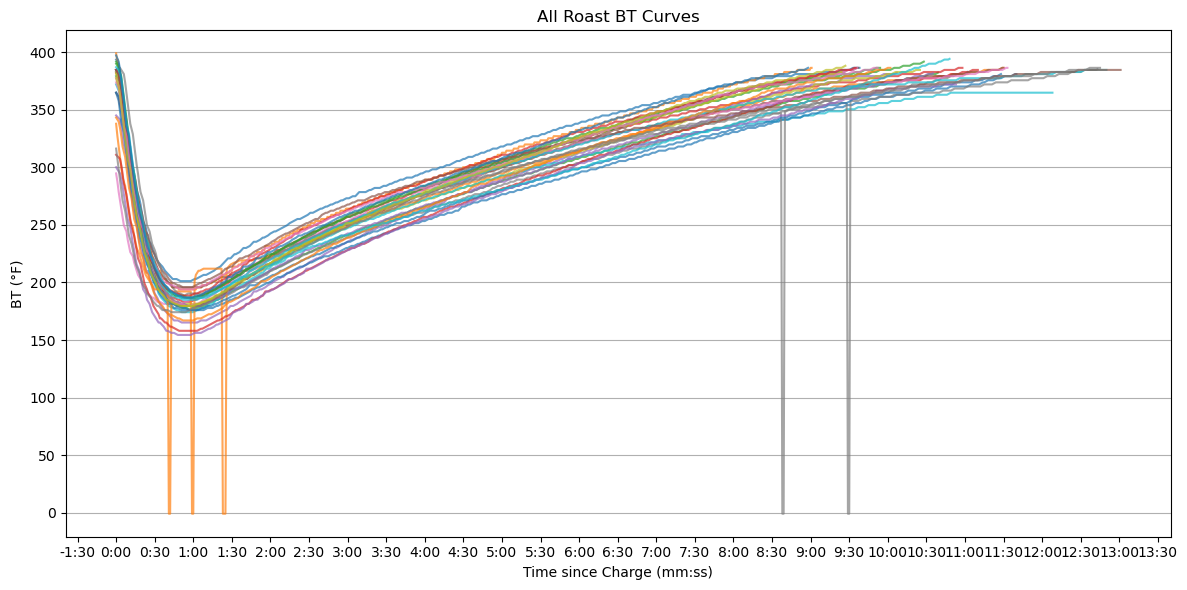

In [9]:
# Plot all BT curves
print("Plotting all BT curves...")
plot_all_curves(scored_df, curve_type="bt", title="All Roast BT Curves")
plt.show()

Plotting all RoR curves...


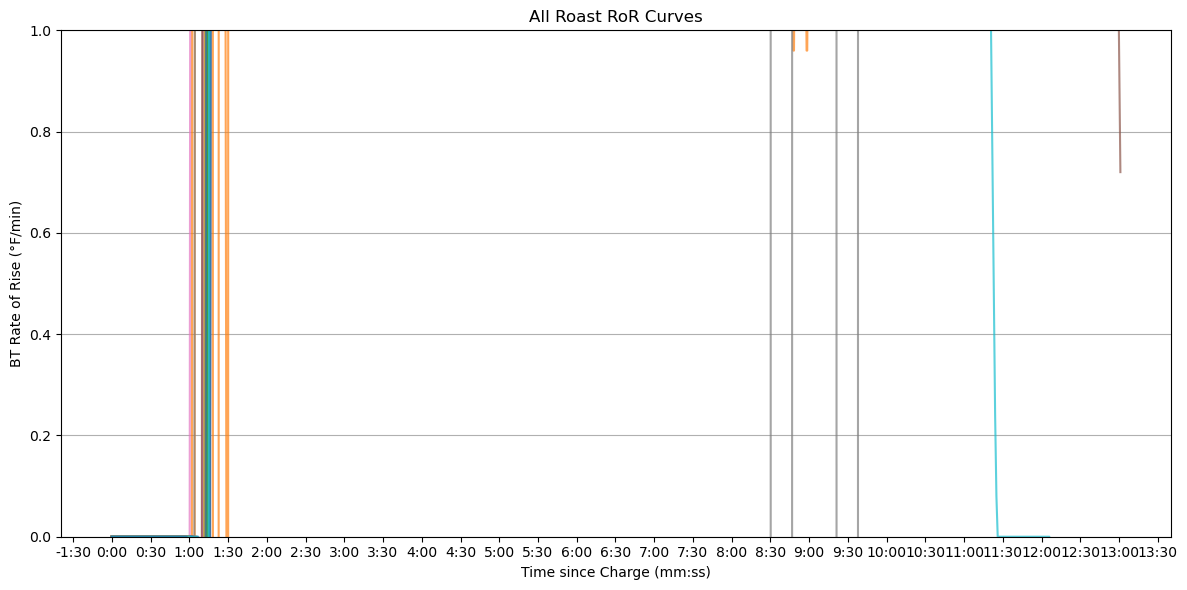

In [10]:
# Plot all RoR curves
print("Plotting all RoR curves...")
plot_all_curves(scored_df, curve_type="ror", title="All Roast RoR Curves")
plt.show()

Generating score analysis plots...


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (2).

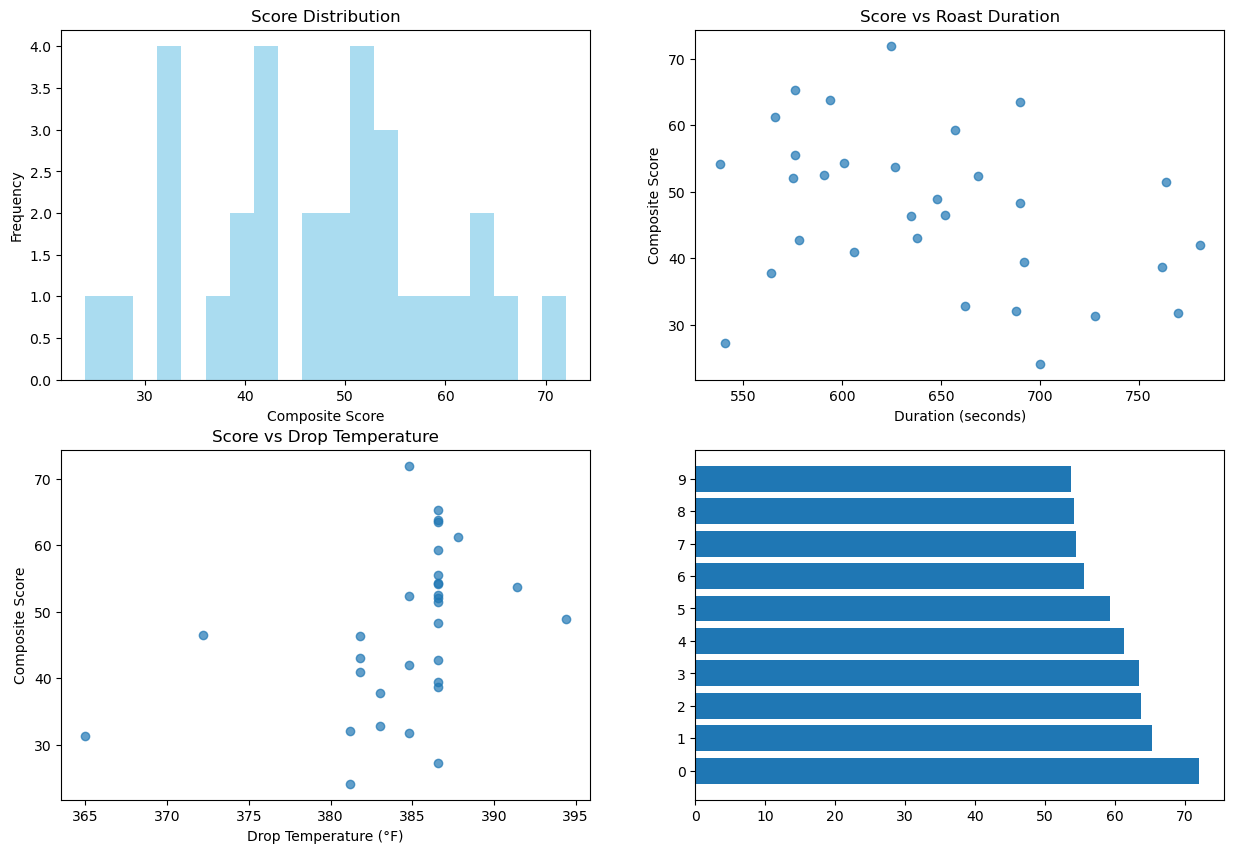

In [11]:
# Score analysis plots
print("Generating score analysis plots...")
plot_score_analysis(scored_df, score_column="composite_score", title="Roast Score Analysis")
plt.show()

## 8. Best vs Worst Roast Comparison

Let's compare the best and worst performing roasts to understand what makes a good roast.

In [ ]:
# Get best and worst roasts
best_roast_idx = scored_df['composite_score'].idxmax()
worst_roast_idx = scored_df['composite_score'].idxmin()

best_roast = scored_df.loc[best_roast_idx]
worst_roast = scored_df.loc[worst_roast_idx]

print("Best vs Worst Roast Comparison:")
print(f"\nBest Roast: {best_roast['filename']} (Score: {best_roast['composite_score']:.1f})")
print(f"  Duration: {best_roast['drop_time']:.0f}s ({best_roast['drop_time']/60:.1f} min)")
print(f"  Drop temp: {best_roast['drop_bt']:.1f}°F")
print(f"  Development ratio: {best_roast['dev_ratio']:.1f}%")
print(f"  Peak RoR: {best_roast['peak_ror']:.1f}°F/min")

print(f"\nWorst Roast: {worst_roast['filename']} (Score: {worst_roast['composite_score']:.1f})")
print(f"  Duration: {worst_roast['drop_time']:.0f}s ({worst_roast['drop_time']/60:.1f} min)")
print(f"  Drop temp: {worst_roast['drop_bt']:.1f}°F")
print(f"  Development ratio: {worst_roast['dev_ratio']:.1f}%")
print(f"  Peak RoR: {worst_roast['peak_ror']:.1f}°F/min")

# Load and plot the individual roast curves for comparison
best_file = Path("data") / f"{best_roast['filename']}.alog"
worst_file = Path("data") / f"{worst_roast['filename']}.alog"

if best_file.exists():
    best_data = extract_roast_data(best_file)
    plot_roast(best_data, title=f"Best Roast: {best_roast['filename']} (Score: {best_roast['composite_score']:.1f})")
    plt.show()

if worst_file.exists():
    worst_data = extract_roast_data(worst_file)
    plot_roast(worst_data, title=f"Worst Roast: {worst_roast['filename']} (Score: {worst_roast['composite_score']:.1f})")
    plt.show()

## 9. Export Results

Save our analysis results for further use.

In [ ]:
# Export results to CSV
output_file = "experiments/roast_analysis_modular_results.csv"

export_columns = [
    'filename', 'composite_score', 'ror_score', 'timing_score', 
    'temp_score', 'dev_score', 'drop_time', 'drop_bt', 'dev_ratio',
    'peak_ror', 'decline_ratio', 'flick_magnitude',
    'drying_time', 'maillard_time', 'development_time'
]

scored_df[export_columns].to_csv(output_file, index=False)
print(f"✓ Results exported to {output_file}")

# Display final summary
print(f"\nFinal Analysis Summary:")
print(f"  Roasts analyzed: {len(scored_df)}")
print(f"  Average composite score: {scored_df['composite_score'].mean():.1f}")
print(f"  Best roast: {best_roast['filename']} ({best_roast['composite_score']:.1f})")
print(f"  Score range: {scored_df['composite_score'].min():.1f} - {scored_df['composite_score'].max():.1f}")

## Summary

This notebook demonstrates the complete coffee roast analysis workflow using the modular functions from main.py:

1. **Data Loading**: Parsed .alog files and handled missing/invalid data
2. **Data Processing**: Applied event annotation, segmentation, cleaning, and normalization
3. **Scoring**: Evaluated roasts using a multi-component scoring system
4. **Visualization**: Generated plots for analysis
5. **Export**: Saved results for further analysis

The modular approach allows for easy customization and reuse of individual components while maintaining all the analytical capabilities of the original workflow.